<a href="https://colab.research.google.com/github/qlin1996/NYC_Property_Sales/blob/master/NYC_Property_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Have some cash on hand and thinking about investing in NYC real estate? Or maybe you have a property and debating about getting rid of it? Whether you are buying or selling property, be sure to read this report before making a decision.

In this report, I analyze New York City Department of Finance's NYC property sales of years 2016-2019 for trends in property location, property demand and sale prices. The specific questions I answer are:

*   How has property demand and sale price fluctuated over the years?
*   What *boroughs* sold the most properties and at what price?
*   What *neigbhorhoods* sold the most properties and at what price?
*   What were hottest buildings in each borough and how much did they sell for?
*   How did the distribution of property size look in each borough?
*   Were there more newer or older properties sold?
*   What affects sale price? Is there a correlation between sale price and land sq ft, gross sq feet, or the year in which the property was built?

# Housekeeping

## Importing Libraries, Reading Data, and Setting Style

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [503]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
full_data = pd.read_csv('/content/drive/My Drive/NYC_Citywide_Annualized_Calendar_Sales_Update.csv')
sns.set(context= 'notebook', style='ticks', palette='muted', font='sans-serifs', font_scale=1.2, color_codes=True, rc={'lines.linewidth': 1.75, 'figure.figsize': (9, 6)})

## Data Dictionary

**BOROUGH**
**NEIGHBORHOOD**
**BUILDING CLASS**: Identifies properties broad usage (e.g. One Family Home).
**ADDRESS**: Note that coop sales include the apartment in the address field.
**ZIP CODE**
**LAND SQUARE FEET**: The land area of the property listed in square feet. 
**GROSS SQUARE FEET**: The total area of all the floors of a building as measured from the exterior surfaces of the
outside walls of the building, including the land area and space within any building or structure
on the property.
**YEAR BUILT**
**SALE PRICE**
**SALE DATE**

## Preview of Raw Data

There were 29 columns and 345,059 rows in the full data set.

In [505]:
# columns, null values, counts, and dtypes
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345059 entries, 0 to 345058
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BOROUGH                          345059 non-null  int64  
 1   NEIGHBORHOOD                     345059 non-null  object 
 2   BUILDING CLASS CATEGORY          345059 non-null  object 
 3   TAX CLASS AS OF FINAL ROLL       341199 non-null  object 
 4   BLOCK                            345059 non-null  int64  
 5   LOT                              345059 non-null  int64  
 6   EASE-MENT                        0 non-null       float64
 7   BUILDING CLASS AS OF FINAL ROLL  341199 non-null  object 
 8   ADDRESS                          345059 non-null  object 
 9   APARTMENT NUMBER                 74790 non-null   object 
 10  ZIP CODE                         345044 non-null  float64
 11  RESIDENTIAL UNITS                329081 non-null  float64
 12  CO

In [506]:
# sample of raw data
full_data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,EASE-MENT,BUILDING CLASS AS OF FINAL ROLL,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,1,FINANCIAL,14 RENTALS - 4-10 UNIT,2A,7,38,NaN,S9,60 PEARL STREET,NaN,10004.0,3.0,2.0,5.0,"1,491","7,485",1900.0,2,S9,4027000,01/01/2016,40.703553,-74.011152,101.0,1.0,9.0,1000014.0,1.000070e+09,Battery Park City-Lower Manhattan
1,1,HARLEM-EAST,01 ONE FAMILY DWELLINGS,1,1643,122,NaN,A4,155 EAST 115 STREET,NaN,10029.0,1.0,0.0,1.0,"1,345","2,800",1900.0,1,A4,0,01/01/2016,40.797761,-73.941667,111.0,8.0,182.0,1052276.0,1.016430e+09,East Harlem North
2,1,HARLEM-EAST,07 RENTALS - WALKUP APARTMENTS,2,1643,123,NaN,C5,157 EAST 115 STREET,NaN,10029.0,12.0,1.0,13.0,"1,345","3,535",1900.0,2,C5,0,01/01/2016,40.797744,-73.941627,111.0,8.0,182.0,1052277.0,1.016430e+09,East Harlem North
3,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1320,4247,NaN,R4,211 EAST 46TH STREET,33J,10017.0,1.0,0.0,1.0,- 0,- 0,1979.0,2,R4,0,01/01/2016,40.753118,-73.972085,106.0,4.0,90.0,1037599.0,1.013208e+09,Turtle Bay-East Midtown
4,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1365,1526,NaN,R4,400 EAST 54TH STREET,30H,10022.0,1.0,0.0,1.0,- 0,- 0,1972.0,2,R4,0,01/01/2016,40.756237,-73.963995,106.0,4.0,8603.0,1076281.0,1.013658e+09,Turtle Bay-East Midtown


## Cleaning Data

I filtered the data by dropping duplicates and columns I chose not to investigate. I renamed the values in the "Borough" so it was easier to read and understand. I also converted the columns to their appropriate data types.

In [507]:
# create a copy
predrop = full_data.copy()

# drop duplicates
predrop.drop_duplicates(keep='first', inplace=True)

# drop irrelevant columns
predrop.drop(columns=['TAX CLASS AT TIME OF SALE','BLOCK', 'TAX CLASS AS OF FINAL ROLL','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LOT', 'EASE-MENT', 'BUILDING CLASS AS OF FINAL ROLL', 'APARTMENT NUMBER', 'TOTAL UNITS', 'BUILDING CLASS AT TIME OF SALE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA'], inplace=True)

# rename columns
predrop.rename(columns={'BUILDING CLASS CATEGORY': 'BUILDING CLASS'}, inplace=True)

# convert the values (1-5) in the "BOROUGH" column to borough names
predrop['BOROUGH'].replace({1:'MANHATTAN', 2:'BRONX', 3: 'BROOKLYN', 4: 'QUEENS', 5:'STATEN ISLAND'}, inplace=True)

# convert 'SALE DATE' to only have year and month and to string format
predrop['SALE DATE'] = pd.to_datetime(predrop['SALE DATE'])
predrop['SALE MONTH'] = predrop['SALE DATE'].dt.month
predrop['SALE YEAR'] = predrop['SALE DATE'].dt.year
predrop.sort_values(by=['SALE YEAR', 'SALE MONTH'], ascending=True, inplace=True)
predrop.drop(columns='SALE DATE', inplace=True)
predrop['SALE MONTH'] = predrop['SALE MONTH'].map(lambda x: str(x))
predrop['SALE MONTH'].replace({'1':'Jan', '2':'Feb', '3': 'Mar', '4': 'Apr', '5':'May', '6':'Jun', '7':'Jul', '8': 'Aug', '9': 'Sept', '10':'Oct',  '11': 'Nov', '12':'Dec'}, inplace=True)
predrop['SALE YEAR'] = predrop['SALE YEAR'].map(lambda x: str(x))
predrop['SALE DATE'] = predrop['SALE MONTH'] + ' ' + predrop['SALE YEAR']
predrop

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
0,MANHATTAN,FINANCIAL,14 RENTALS - 4-10 UNIT,60 PEARL STREET,10004.0,"1,491","7,485",1900.0,4027000,Jan,2016,Jan 2016
1,MANHATTAN,HARLEM-EAST,01 ONE FAMILY DWELLINGS,155 EAST 115 STREET,10029.0,"1,345","2,800",1900.0,0,Jan,2016,Jan 2016
2,MANHATTAN,HARLEM-EAST,07 RENTALS - WALKUP APARTMENTS,157 EAST 115 STREET,10029.0,"1,345","3,535",1900.0,0,Jan,2016,Jan 2016
3,MANHATTAN,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,211 EAST 46TH STREET,10017.0,- 0,- 0,1979.0,0,Jan,2016,Jan 2016
4,MANHATTAN,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,400 EAST 54TH STREET,10022.0,- 0,- 0,1972.0,0,Jan,2016,Jan 2016
...,...,...,...,...,...,...,...,...,...,...,...,...
344344,STATEN ISLAND,WOODROW,01 ONE FAMILY DWELLINGS,21 SONIA COURT,10309.0,"3,020","1,800",1996.0,560000,Dec,2019,Dec 2019
344347,STATEN ISLAND,WOODROW,01 ONE FAMILY DWELLINGS,41 PITNEY AVENUE,10309.0,"4,000","1,775",1935.0,0,Dec,2019,Dec 2019
344381,STATEN ISLAND,WOODROW,02 TWO FAMILY DWELLINGS,105 BERKSHIRE LANE,10309.0,"4,335","2,402",2017.0,150000,Dec,2019,Dec 2019
344398,STATEN ISLAND,WOODROW,02 TWO FAMILY DWELLINGS,140 SHARROTTS ROAD,10309.0,"2,680","1,420",1996.0,555000,Dec,2019,Dec 2019


I also cleaned the "BUILDING CLASS" column and got rid of duplicates that were not dropped during the first round because they had weird spacing in it. Figuring out there were duplicates was a painful process because upon first glance, the values all appeared all unique. It wasn't until I graphed building classes by borough and started questioning the results that I realized that this column had funky data in it.

In [508]:
# what the 'BUILDING CLASS' looked like pre-cleaned. The extra spacing between the number and the name caused the system to not read it as duplicates.
print(predrop['BUILDING CLASS'].nunique())
print(predrop['BUILDING CLASS'].unique())

91
['14  RENTALS - 4-10 UNIT' '01  ONE FAMILY DWELLINGS'
 '07  RENTALS - WALKUP APARTMENTS' '13  CONDOS - ELEVATOR APARTMENTS'
 '26  OTHER HOTELS' '47  CONDO NON-BUSINESS STORAGE' '22  STORE BUILDINGS'
 '21  OFFICE BUILDINGS' '31  COMMERCIAL VACANT LAND'
 '35  INDOOR PUBLIC AND CULTURAL FACILITIES' '05  TAX CLASS 1 VACANT LAND'
 '08  RENTALS - ELEVATOR APARTMENTS' '29  COMMERCIAL GARAGES'
 '02  TWO FAMILY DWELLINGS' '10  COOPS - ELEVATOR APARTMENTS'
 '03  THREE FAMILY DWELLINGS' '04  TAX CLASS 1 CONDOS' '45  CONDO HOTELS'
 '15  CONDOS - 2-10 UNIT RESIDENTIAL' '09  COOPS - WALKUP APARTMENTS'
 '44  CONDO PARKING' '34  THEATRES' '12  CONDOS - WALKUP APARTMENTS'
 '17  CONDO COOPS' '30  WAREHOUSES' '37  RELIGIOUS FACILITIES'
 '43  CONDO OFFICE BUILDINGS' '27  FACTORIES' '06  TAX CLASS 1 - OTHER'
 '16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT' '41  TAX CLASS 4 - OTHER'
 '32  HOSPITAL AND HEALTH FACILITIES' '25  LUXURY HOTELS'
 '49  CONDO WAREHOUSES/FACTORY/INDUS' '46  CONDO STORE BUILDINGS'
 

In [509]:
# after filtering out first two number and the extra space, there were 47 unique building types 
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].str[3:]
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].apply(lambda x : x[1:] if x.startswith(" ") else x)
print(predrop['BUILDING CLASS'].nunique())
print(predrop['BUILDING CLASS'].unique())

47
['RENTALS - 4-10 UNIT' 'ONE FAMILY DWELLINGS'
 'RENTALS - WALKUP APARTMENTS' 'CONDOS - ELEVATOR APARTMENTS'
 'OTHER HOTELS' 'CONDO NON-BUSINESS STORAGE' 'STORE BUILDINGS'
 'OFFICE BUILDINGS' 'COMMERCIAL VACANT LAND'
 'INDOOR PUBLIC AND CULTURAL FACILITIES' 'TAX CLASS 1 VACANT LAND'
 'RENTALS - ELEVATOR APARTMENTS' 'COMMERCIAL GARAGES'
 'TWO FAMILY DWELLINGS' 'COOPS - ELEVATOR APARTMENTS'
 'THREE FAMILY DWELLINGS' 'TAX CLASS 1 CONDOS' 'CONDO HOTELS'
 'CONDOS - 2-10 UNIT RESIDENTIAL' 'COOPS - WALKUP APARTMENTS'
 'CONDO PARKING' 'THEATRES' 'CONDOS - WALKUP APARTMENTS' 'CONDO COOPS'
 'WAREHOUSES' 'RELIGIOUS FACILITIES' 'CONDO OFFICE BUILDINGS' 'FACTORIES'
 'TAX CLASS 1 - OTHER' 'CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT'
 'TAX CLASS 4 - OTHER' 'HOSPITAL AND HEALTH FACILITIES' 'LUXURY HOTELS'
 'CONDO WAREHOUSES/FACTORY/INDUS' 'CONDO STORE BUILDINGS' 'LOFT BUILDINGS'
 'EDUCATIONAL FACILITIES' 'CONDO TERRACES/GARDENS/CABANAS'
 'ASYLUMS AND HOMES' 'COMMERCIAL CONDOS' 'CONDO-RENTALS'
 'TAX CLA

For the "SALE PRICE" column, I filtered out sale prices <= $0 because as I consider those as a mere transfer of ownership and not a sale. 

In [0]:
# make a copy for dropping values
nyc_property_sales = predrop.copy()

# filter out property sale price of < $0
def price_filter(price):
  if (price<=0):
    return np.NaN
  else: 
    return price
nyc_property_sales['SALE PRICE'] = nyc_property_sales['SALE PRICE'].apply(price_filter)

Moving on to the "LAND SQUARE FEET" and "GROSS SQUARE FEET" columns, I dropped negative values and converted the dtypes to int.

In [511]:
# count number of -0 values for later use
print(len(nyc_property_sales[nyc_property_sales['LAND SQUARE FEET']=='- 0']))
print(len(nyc_property_sales[nyc_property_sales['GROSS SQUARE FEET']=='- 0']))

# convert 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' to numbers. if value is null, fill with -1 so we can drop it later.
nyc_property_sales['LAND SQUARE FEET'] = nyc_property_sales['LAND SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)
nyc_property_sales['GROSS SQUARE FEET'] = nyc_property_sales['GROSS SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)

74668
85507


In [0]:
# delete rows with null values and rows with -1 in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET'
nyc_property_sales.dropna(axis=0, how='any', inplace=True)
nyc_property_sales.drop = nyc_property_sales[(nyc_property_sales['LAND SQUARE FEET']!=-1) | (nyc_property_sales['GROSS SQUARE FEET']!=-1)]

For the "ZIP CODE" and "YEAR BUILT" columns, I noticed the minimum values were 0. As there are no zipcode of 00000 and realistically no properties built in the year 0, I dropped these values too. I then converted the dtypes of these two columns to int.

In [513]:
# description of each numeric column
nyc_property_sales.describe()

,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,235615.000000,2.356150e+05,2.356150e+05,235615.000000,2.356150e+05
mean,10735.330157,3.563223e+03,2.590575e+03,1831.343976,1.639040e+06
std,1107.770934,6.618815e+04,2.444331e+04,468.579948,1.450745e+07
min,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,10301.000000,0.000000e+00,0.000000e+00,1920.000000,3.820000e+05
50%,11206.000000,1.600000e+03,1.012000e+03,1940.000000,6.400000e+05
75%,11357.000000,2.660000e+03,1.950000e+03,1966.000000,1.080000e+06
max,11697.000000,1.985040e+07,3.750565e+06,2020.000000,2.397502e+09


In [0]:
# drop rows with 0 'ZIP CODE' or 'YEAR BUILT'
nyc_property_sales = nyc_property_sales[nyc_property_sales['ZIP CODE']>0]
nyc_property_sales = nyc_property_sales[nyc_property_sales['YEAR BUILT']>0]

# convert 'ZIP CODE' and 'YEAR BUILT' from float to int
nyc_property_sales['ZIP CODE']=nyc_property_sales['ZIP CODE'].map(lambda x: int(x))
nyc_property_sales['YEAR BUILT']=nyc_property_sales['YEAR BUILT'].map(lambda x: int(x))

Below is a summary of what was dropped from each column. Note that >20% of values in the Land Square Feet, Gross Square Feet, and Sale Price columns were dropped. Please keep in mind that had we not dropped these values, our results could have been different.

In [515]:
# count how many were nulls/0s/invalid values for each column
invalids_cells = pd.DataFrame([],index = nyc_property_sales.columns, columns=['Invalid Counts Dropped (%)'])
invalids_cells.loc['BOROUGH'] = (len(nyc_property_sales)-nyc_property_sales['BOROUGH'].count()) / len(predrop) * 100
invalids_cells.loc['NEIGHBORHOOD'] = (len(nyc_property_sales)-nyc_property_sales['NEIGHBORHOOD'].count()) /len(predrop) * 100
invalids_cells.loc['BUILDING CLASS'] = (len(nyc_property_sales)-nyc_property_sales['BUILDING CLASS'].count()) / len(predrop) * 100
invalids_cells.loc['ADDRESS'] = (len(nyc_property_sales)-nyc_property_sales['ADDRESS'].count()) / len(predrop) * 100
invalids_cells.loc['ZIP CODE'] = ((len(nyc_property_sales)-nyc_property_sales['ZIP CODE'].count())  + len(predrop[predrop['ZIP CODE']==0.0])) / len(predrop) * 100
invalids_cells.loc['LAND SQUARE FEET'] = (len(nyc_property_sales)-nyc_property_sales['LAND SQUARE FEET'].count() + 74669) / len(predrop) * 100
invalids_cells.loc['GROSS SQUARE FEET'] = (len(nyc_property_sales)-nyc_property_sales['GROSS SQUARE FEET'].count() + 85507) / len(predrop) * 100
invalids_cells.loc['YEAR BUILT'] = ((len(nyc_property_sales)-nyc_property_sales['YEAR BUILT'].count()) + len(predrop[predrop['YEAR BUILT']==0.0])) / len(predrop) * 100
invalids_cells.loc['SALE PRICE'] = ((len(nyc_property_sales)-nyc_property_sales['SALE PRICE'].count()) + len(predrop[predrop['SALE PRICE']<=0.0])) / len(predrop) * 100
invalids_cells.loc['SALE DATE'] = (len(nyc_property_sales)-nyc_property_sales['SALE DATE'].count()) / len(predrop) * 100
invalids_cells

,Invalid Counts Dropped (%)
BOROUGH,0
NEIGHBORHOOD,0
BUILDING CLASS,0
ADDRESS,0
ZIP CODE,0.807323
LAND SQUARE FEET,21.8176
GROSS SQUARE FEET,24.9844
YEAR BUILT,6.87058
SALE PRICE,30.103
SALE MONTH,NaN


## Preview of Cleaned Sample

In [516]:
# columns, null values, counts, and dtypes
nyc_property_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220940 entries, 0 to 344398
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   BOROUGH            220940 non-null  object 
 1   NEIGHBORHOOD       220940 non-null  object 
 2   BUILDING CLASS     220940 non-null  object 
 3   ADDRESS            220940 non-null  object 
 4   ZIP CODE           220940 non-null  int64  
 5   LAND SQUARE FEET   220940 non-null  int64  
 6   GROSS SQUARE FEET  220940 non-null  int64  
 7   YEAR BUILT         220940 non-null  int64  
 8   SALE PRICE         220940 non-null  float64
 9   SALE MONTH         220940 non-null  object 
 10  SALE YEAR          220940 non-null  object 
 11  SALE DATE          220940 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 21.9+ MB


In [517]:
# sample data post-cleaned
nyc_property_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
0,MANHATTAN,FINANCIAL,RENTALS - 4-10 UNIT,60 PEARL STREET,10004,1491,7485,1900,4027000.0,Jan,2016,Jan 2016
14,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,10462,12500,22680,1932,384000.0,Jan,2016,Jan 2016
16,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,10462,12500,22680,1932,2288000.0,Jan,2016,Jan 2016
19,BRONX,SCHUYLERVILLE/PELHAM BAY,OFFICE BUILDINGS,3049 BUHRE AVENUE,10461,7550,8550,1925,336000.0,Jan,2016,Jan 2016
24,BRONX,SCHUYLERVILLE/PELHAM BAY,INDOOR PUBLIC AND CULTURAL FACILITIES,3060 WESTCHESTER AVENUE,10461,4568,4568,1937,480000.0,Jan,2016,Jan 2016


# Data Analysis and Visualization

## How has property demand and sale price fluctuated over the years?

I start my analysis by examining the fluctuation of property demand of NYC as a whole.

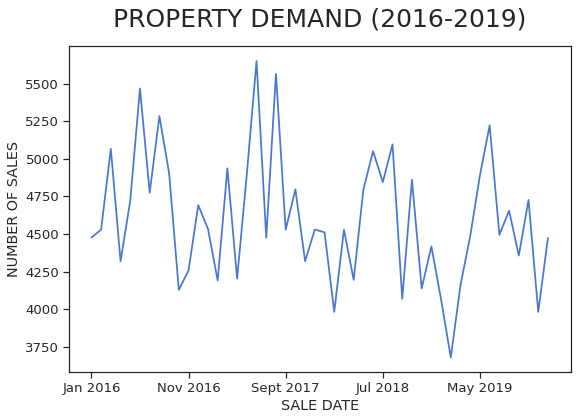

In [546]:
# Time and number of property sales
date_df = nyc_property_sales.groupby('SALE DATE', sort=False)['SALE PRICE'].count()

date_df.plot.line()
plt.title('PROPERTY DEMAND (2016-2019)', fontsize=25, pad=20)
plt.ylabel('NUMBER OF SALES')
plt.show()

In [519]:
# Min and max number of sales by month,year
print(f'Min: {date_df.sort_values().index[0]}, {date_df.sort_values().iloc[0]}')
print(f'Max: {date_df.sort_values(ascending=False).index[0]}, {date_df.sort_values(ascending=False).iloc[0]}')

Min: Feb 2019, 3679
Max: Jun 2017, 5651


The numbers of monthly property sales between 2016-2019 vary greatly. Sales were at their lowest in June 2017 and their highest in February 2019. Also notice how the peaks and drops are pretty consistently spaced out. This got me wondering if there was a sales trend by months.

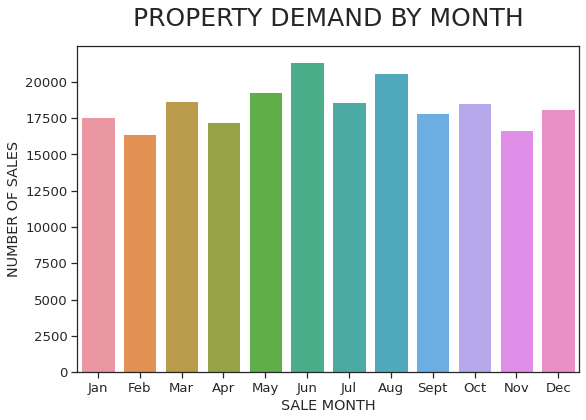

In [520]:
# Month and number of property sales
month_df = nyc_property_sales.groupby('SALE MONTH', sort=False)['SALE PRICE'].count()
month_df = month_df.reset_index().rename(columns={'SALE PRICE':'NUMBER OF SALES'})

sns.barplot(x='SALE MONTH', y='NUMBER OF SALES', data=month_df)
plt.title('PROPERTY DEMAND BY MONTH', fontsize=25, pad=20)
plt.show()

As I have suspected, most properties were sold during the warmer months.

So what about average property sale price?

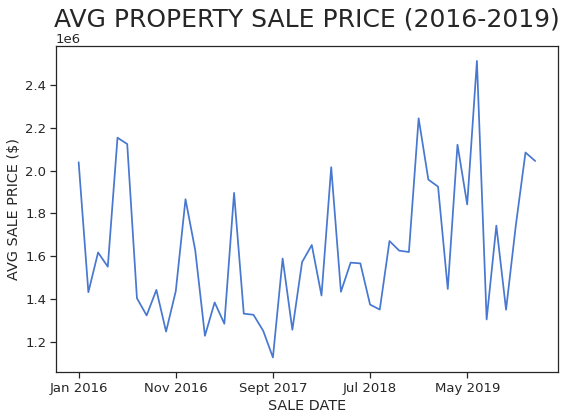

In [547]:
# Time and sale price 
date_df = nyc_property_sales.groupby('SALE DATE', sort=False)['SALE PRICE'].mean()

date_df.plot.line()
plt.title('AVG PROPERTY SALE PRICE (2016-2019)', fontsize=25, pad=20)
plt.ylabel('AVG SALE PRICE ($)')
plt.show()

I see that the average property sales prices also fluctuate greatly and that there is a small upward trend of price increase with time.

## What boroughs sold the most properties and at what price?

I continue my analysis by breaking down the number of sales by borough. My goal was to figure out which borough had the most property sales and at what average price.

In [522]:
# Breakdown of sales count and price by borough
nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
BRONX,20039.0,8.910188e+05,3.342584e+06,1.0,255000.0,449500.0,635000.0,1.334000e+08
BROOKLYN,55800.0,1.343807e+06,5.914381e+06,1.0,463955.0,765000.0,1265000.0,8.696129e+08
MANHATTAN,51325.0,3.795824e+06,2.937839e+07,1.0,615000.0,1084436.0,2350000.0,2.397502e+09
QUEENS,70024.0,8.455060e+05,4.739821e+06,1.0,308925.0,525000.0,810000.0,4.750000e+08
STATEN ISLAND,23752.0,5.375472e+05,7.853859e+05,1.0,350000.0,485000.0,632000.0,5.200000e+07


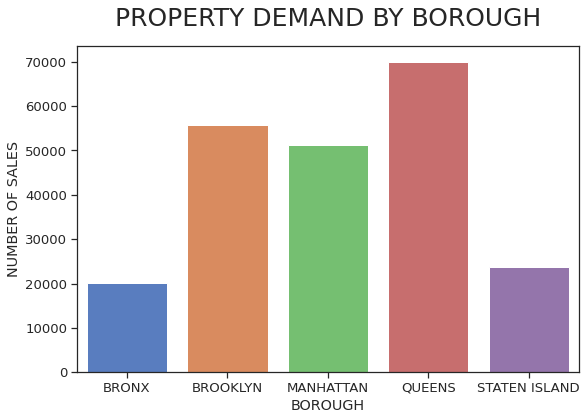

In [523]:
# Number of sales by borough
sales_by_borough_count = nyc_property_sales.groupby('BOROUGH')['SALE DATE'].count()
sales_by_borough = sales_by_borough_count.reset_index().rename(columns={'SALE DATE':'NUMBER OF SALES'})

sns.barplot(x='BOROUGH', y= 'NUMBER OF SALES', data=sales_by_borough)
plt.title('PROPERTY DEMAND BY BOROUGH', fontsize=25, pad=20)
plt.show()

After some computation, I found that borough with the most property sales was Queens with 70,024 sales, followed by Brookylyn with 55,800 sales. Manhattan came in third with 51,325 sales and Staten Island fourth with 23752 sales. Bronx ranked last with only 20,039 property sales.

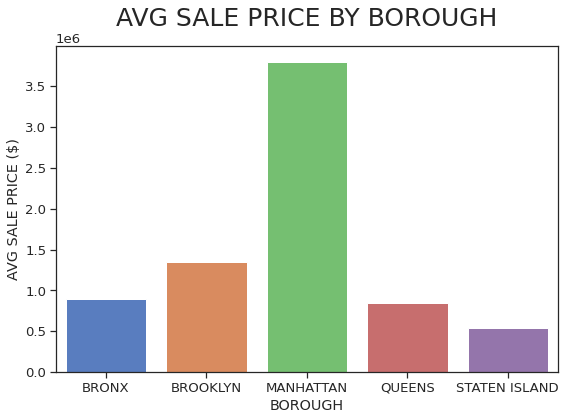

In [524]:
# Avg sale price by borough
mean_price_by_borough = nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].mean()
mean_price_by_borough = mean_price_by_borough.reset_index()

sns.barplot(x='BOROUGH', y='SALE PRICE', data=mean_price_by_borough)
plt.title('AVG SALE PRICE BY BOROUGH', fontsize=25, pad=20)
plt.ylabel('AVG SALE PRICE ($)')
plt.show()

Although Queens saw the most demand, properties were most expensive in Manhattan. The average price of which properties sold for in Manhattan was \$3.8m while in Queens, the average price was \$850k. Staten Island was the cheapest with an average price of \$538k.

If you were worried about the outliers affecting the data, well don't because I also graphed the distribution of the sale price.

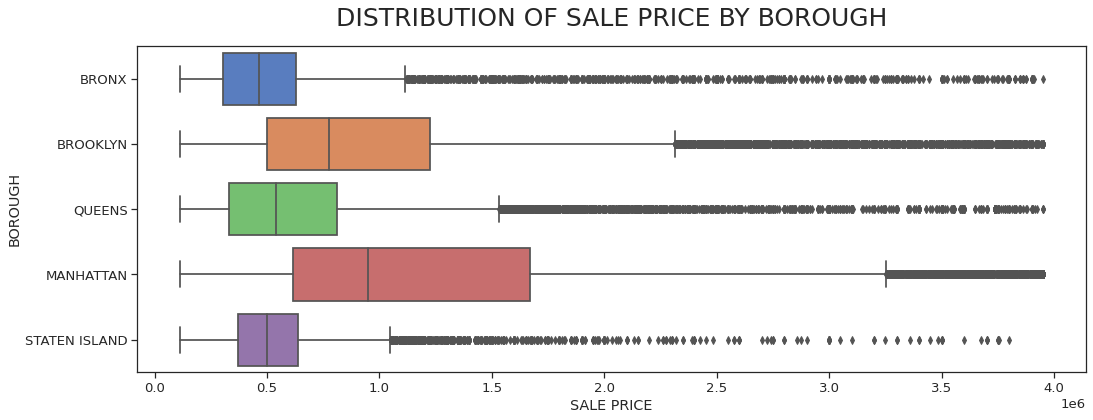

In [525]:
# Distribution of price by borough
sqft_cleaned = nyc_property_sales[nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.05), nyc_property_sales['SALE PRICE'].quantile(.95))]
plt.figure(figsize=(17,6))
sns.boxplot(x='SALE PRICE', y='BOROUGH', data=sqft_cleaned)
plt.title('DISTRIBUTION OF SALE PRICE BY BOROUGH', fontsize=25, pad=20)
plt.show()

The properties in Manhattan also had a higher medium sale price than the other boroughs. 

## What neigborhoods sold the most properties and at what price?

After determining the breakdown by boroughs, I wanted to know how the numbers looked when grouped by neigborhoods. I wanted to determine the number of sales and average property sale price across the most and least in-demand neigborhoods.

In [526]:
# Breakdown of sales count by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count().reset_index().rename(columns={'SALE DATE':'COUNT'}).sort_values(by='COUNT', ascending=False)

,NEIGHBORHOOD,COUNT
90,FLUSHING-NORTH,6637
232,UPPER EAST SIDE (59-79),5317
233,UPPER EAST SIDE (79-96),4776
154,MIDTOWN EAST,3640
235,UPPER WEST SIDE (59-79),3519
...,...,...
50,CO-OP CITY,7
192,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3


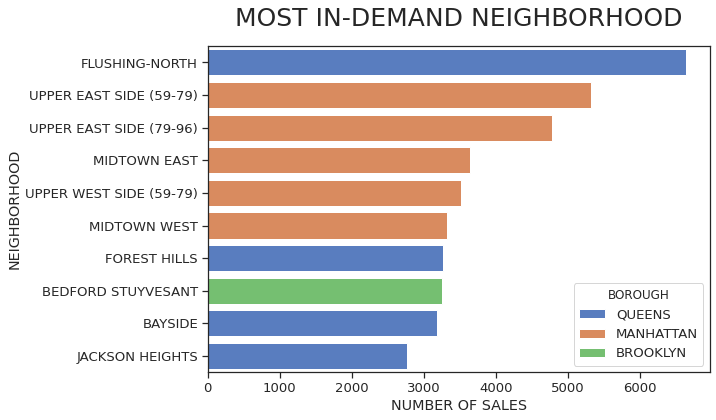

In [527]:
# Top 10 number of sales by neigborhood, color coded by borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=False, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'NUMBER OF SALES'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='NUMBER OF SALES', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.title('MOST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

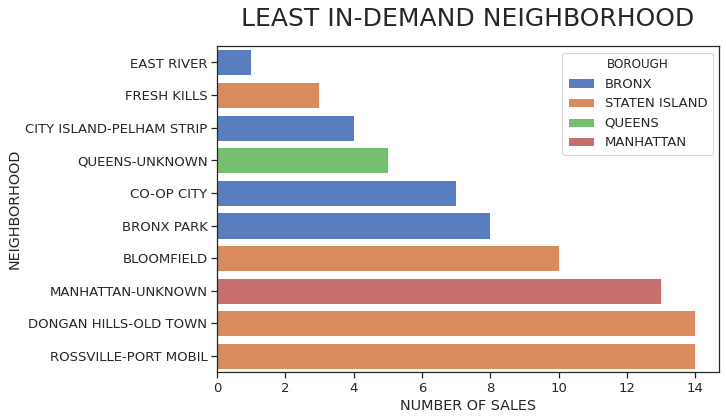

In [528]:
# Bottom 10 Number of Sales by Borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=True, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'NUMBER OF SALES'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='NUMBER OF SALES', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.title('LEAST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

The numbers of properties sold by neighborhood is pretty consistent with our previous analysis on the number of properties sold by borough. The top most in-demand neighborhoods were in Queens and Manhattan (ranked first and third in properties sold by borough) and the top least in-demand neigborhoods were in Bronx and Staten Island (ranked fifth and fourth in properties sold by borough).

In [529]:
# Breakdown of sale price by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].count().reset_index().sort_values(by='SALE PRICE', ascending=False)

,NEIGHBORHOOD,SALE PRICE
90,FLUSHING-NORTH,6637
232,UPPER EAST SIDE (59-79),5317
233,UPPER EAST SIDE (79-96),4776
154,MIDTOWN EAST,3640
235,UPPER WEST SIDE (59-79),3519
...,...,...
50,CO-OP CITY,7
192,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3


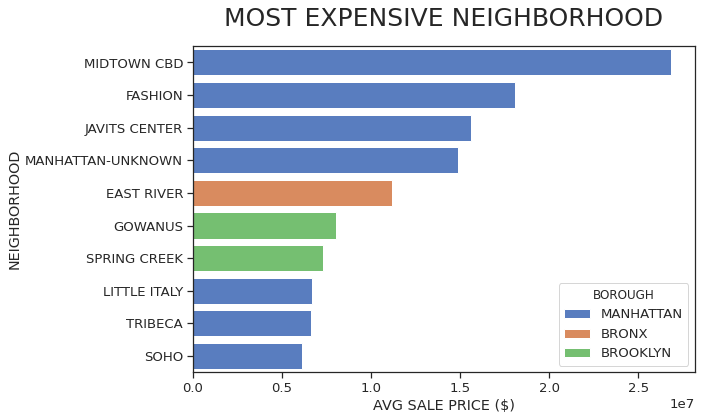

In [530]:
# Sale Price of Top 10 Neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=False, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('MOST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

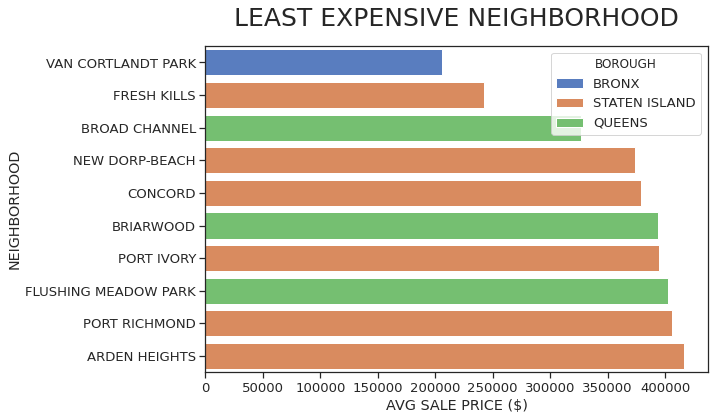

In [531]:
# Sale Price of Bottom 10 Neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=True, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('LEAST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

The average price of properties sold by neighborhood is also pretty consistent with the average price of properties sold by borough. 7 of the top 10 most expensive neigborhoods were in Manhattan, which matches with what was had previously found. 7 of the top 10 least expensive neighorhoods were in Staten Island and Bronx which also matches with what we found earlier.

## What were hottest buildings in each borough and how much did they sell for?

Now that we know the demand and price of properties, we can't help but wonder the type of buildings that these properties were. In this section, we examine for the most in-demand and most expensive building classes sold.

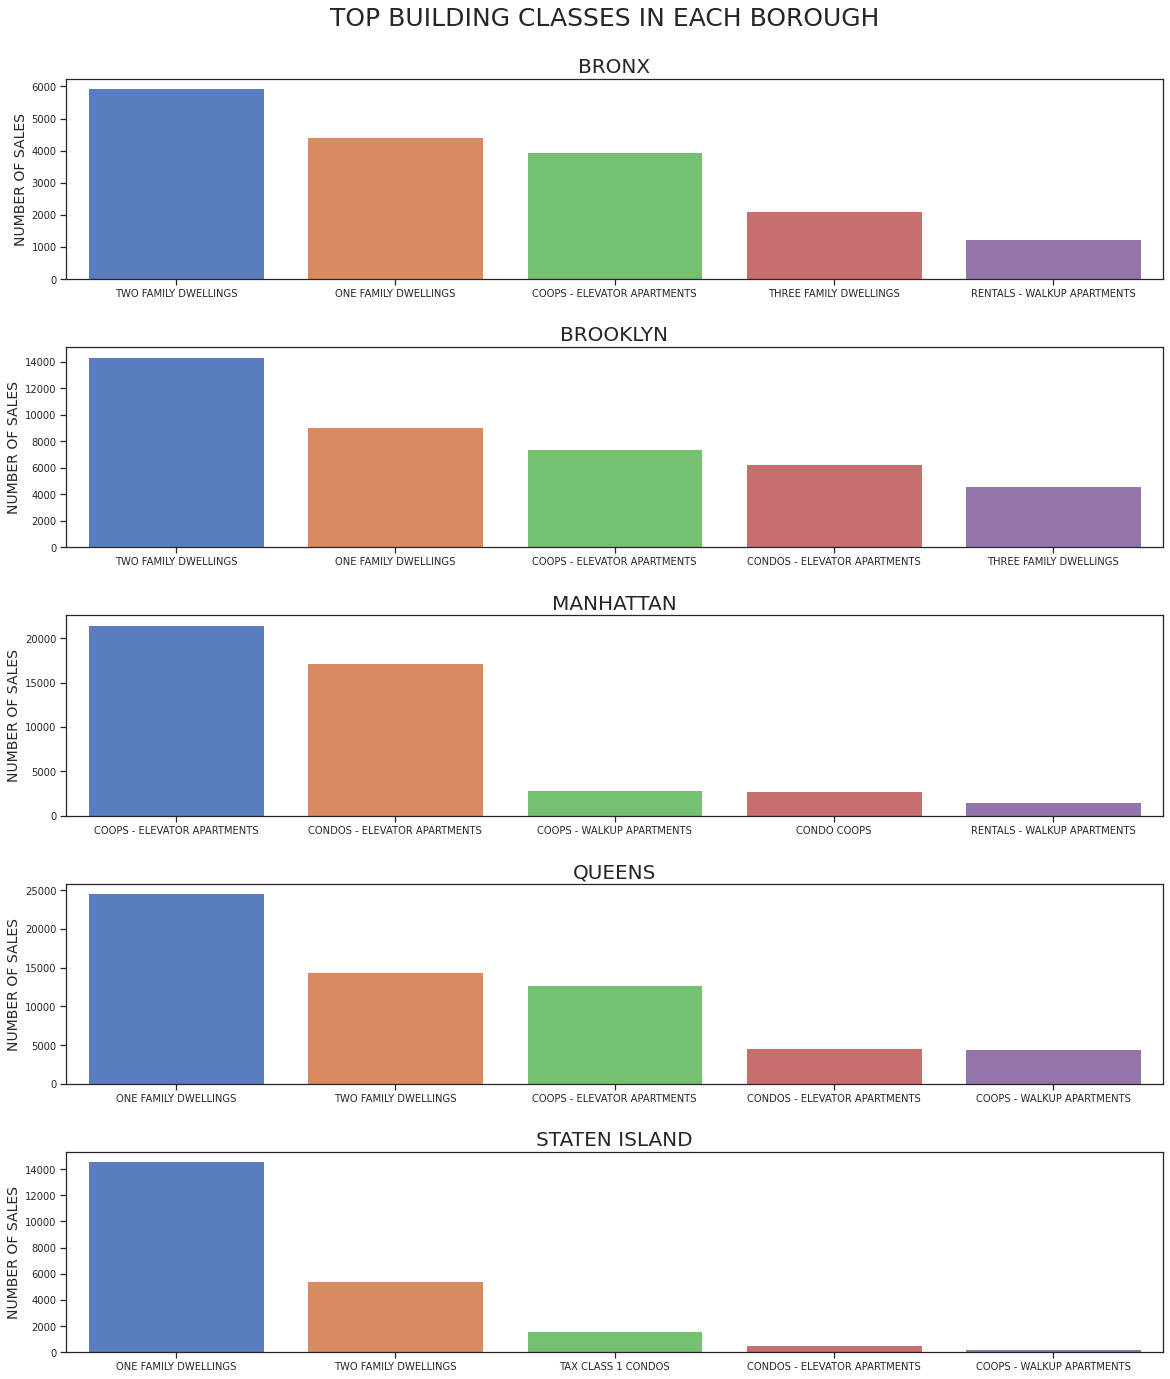

In [532]:
# Top 5 building classes sold in each borough 
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('TOP BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  b = sns.barplot(y='BUILDING CLASS', x='index', data=building_by_borough.get_group(group)['BUILDING CLASS'].value_counts().head(5).reset_index(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('NUMBER OF SALES',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()

The most in-demand building classes in the Bronx, Brooklyn, Queens and Staten Island were one/two family dwellings. This makes me think that these 4 boroughs are more spacious and are attractive to families. Meanwhile in Manhattan, Coops and Condo are more popular which makes sense as space is more limited in the city.

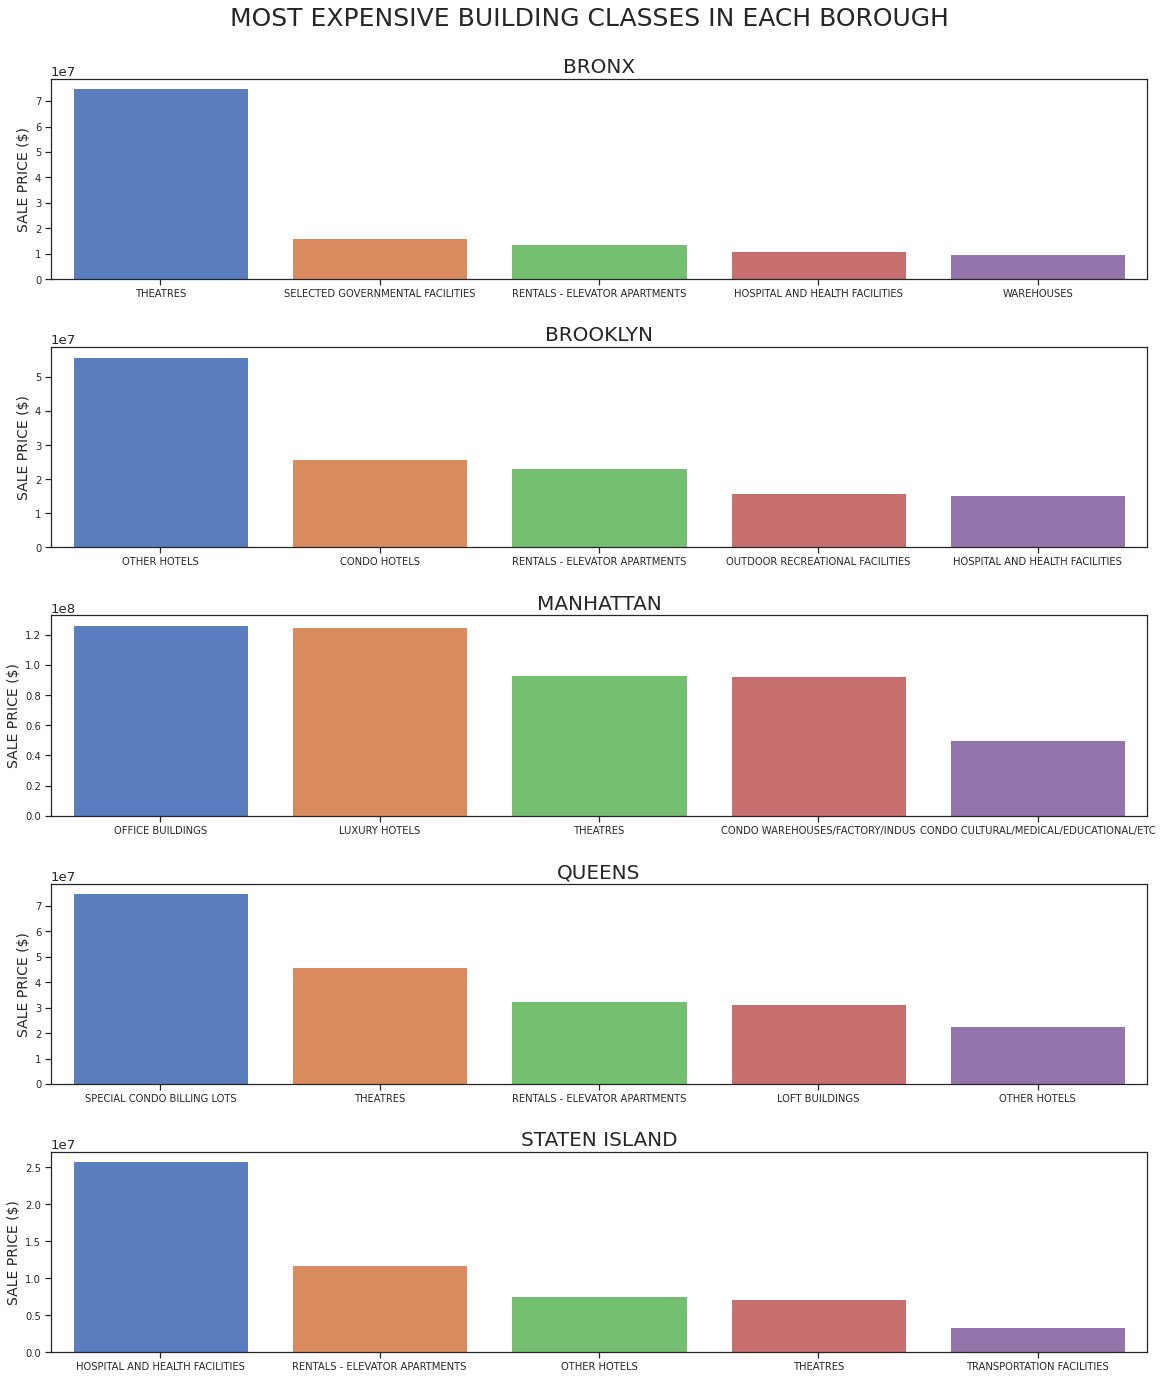

In [533]:
# Most expensive building classes sold in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('MOST EXPENSIVE BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=False).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('SALE PRICE ($)',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()


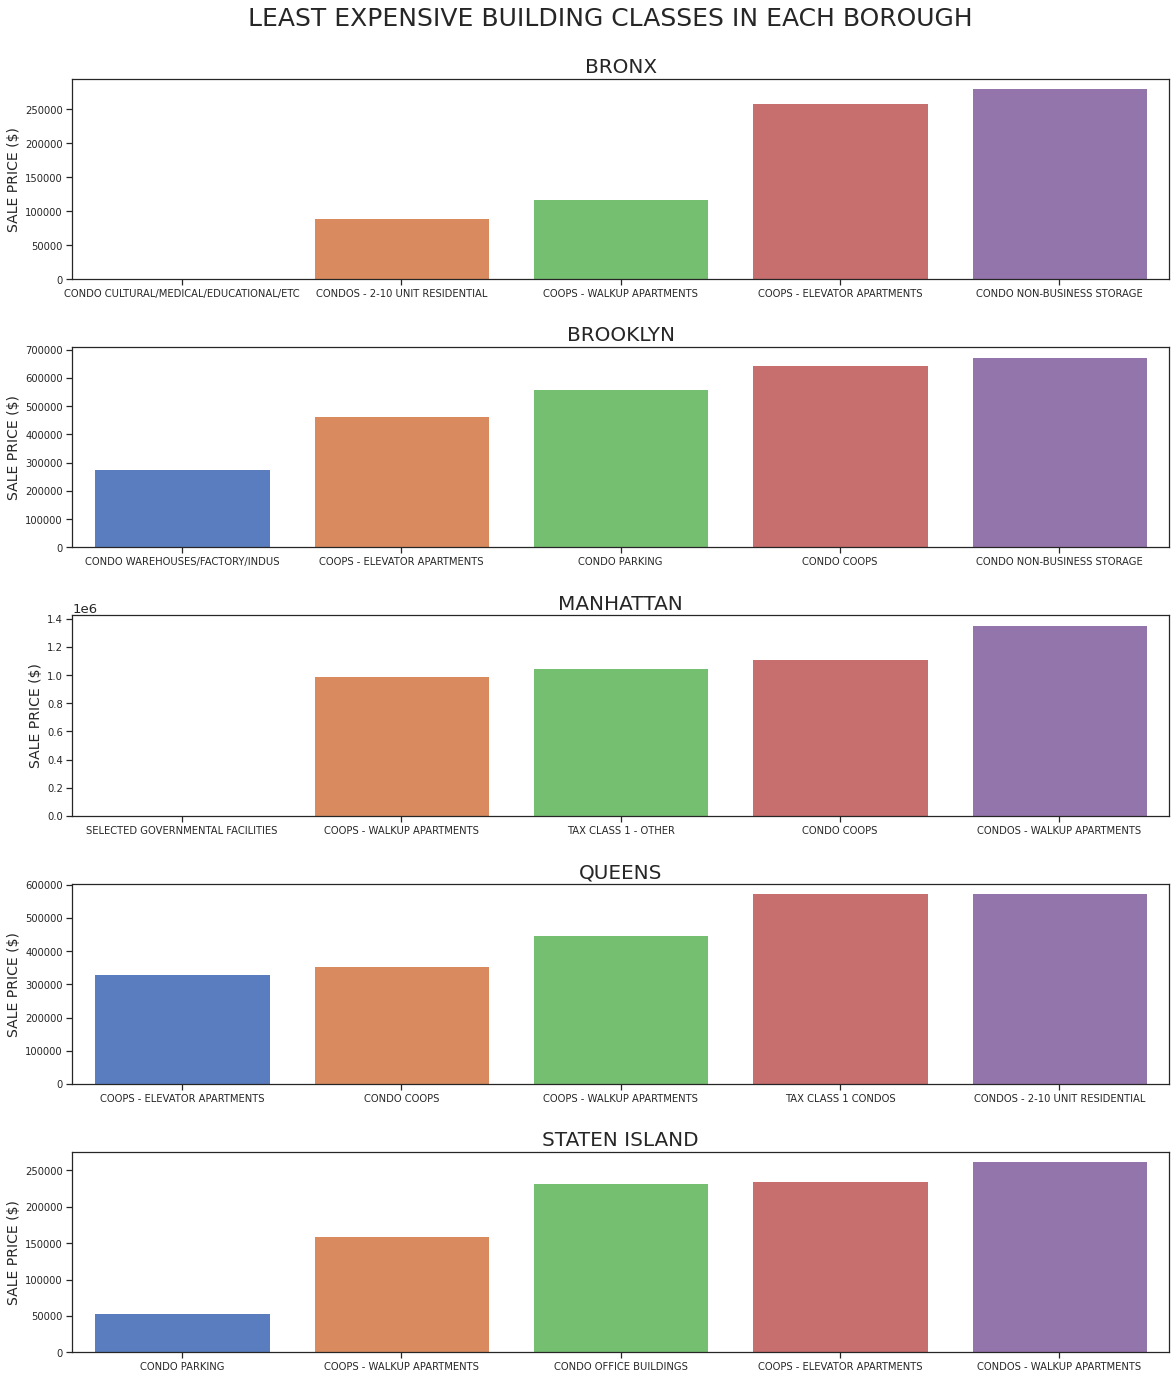

In [534]:
# The least expensive building classes in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(17,20))
fig.tight_layout(pad=3)
fig.suptitle('LEAST EXPENSIVE BUILDING CLASSES IN EACH BOROUGH', fontsize=25)
fig.subplots_adjust(top=0.93)

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=True).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.set_ylabel('SALE PRICE ($)',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group, fontsize=20)

fig.show()

Notice that the most expensive properties in each borough were commerical buildings such as theaters, hotels and office buildings while the least expensive properties were residental buildings such as Coops and Condos. Also notice that two government facilities with a sale price of $1 made it to the least expensive building class in Manhattan list. Details on the two buildings and their sales transaction are listed below. 

In [535]:
nyc_property_sales[(nyc_property_sales['BOROUGH']=='MANHATTAN')&(nyc_property_sales['BUILDING CLASS']=='SELECTED GOVERNMENTAL FACILITIES')]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE MONTH,SALE YEAR,SALE DATE
90070,MANHATTAN,HARLEM-CENTRAL,SELECTED GOVERNMENTAL FACILITIES,120 EAST 125 STREET,10035,2523,8500,1950,1.0,Jan,2017,Jan 2017
161911,MANHATTAN,LOWER EAST SIDE,SELECTED GOVERNMENTAL FACILITIES,269 HENRY STREET,10002,1962,6041,1900,1.0,Oct,2017,Oct 2017


## How did the distribution of property size look in each borough?

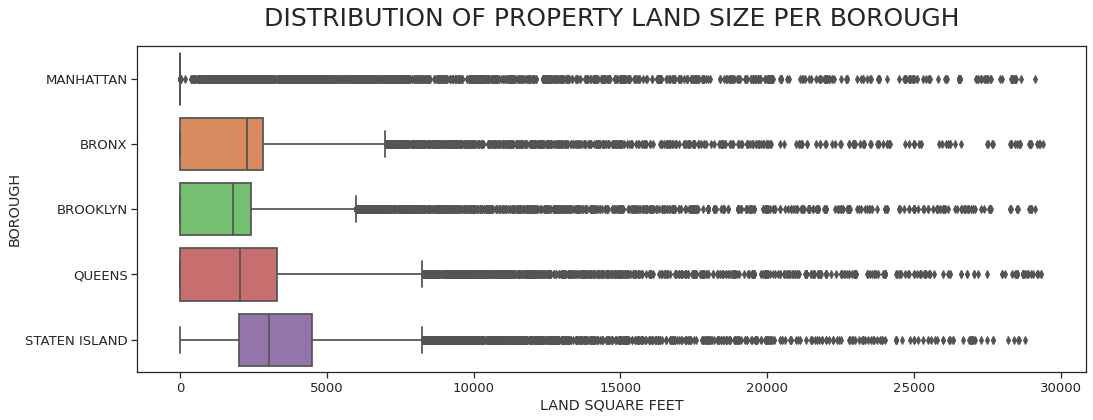

In [536]:
# Land square feet across boroughs. We graphed btw the 0.01 and 0.99 quantile just for visual purposes.
sqft_cleaned = nyc_property_sales[nyc_property_sales['LAND SQUARE FEET'].between(nyc_property_sales['LAND SQUARE FEET'].quantile(.01), nyc_property_sales['LAND SQUARE FEET'].quantile(.99))]
plt.figure(figsize=(17,6))
sns.boxplot(x='LAND SQUARE FEET', y='BOROUGH', data=sqft_cleaned)
plt.title('DISTRIBUTION OF PROPERTY LAND SIZE PER BOROUGH', fontsize=25, pad=20)
plt.show()

Ploting the spread of land square feet for properties sold, we see that the 4 boroughs we mentioned before, Bronx, Brooklyn, Queens, and Staten Island indeed are generally more spacious than Manhattan. These 4 boroughs have a higher interquartile range when it comes to land square feet than Manhattan. 

##  Were there more newer or older properties sold?

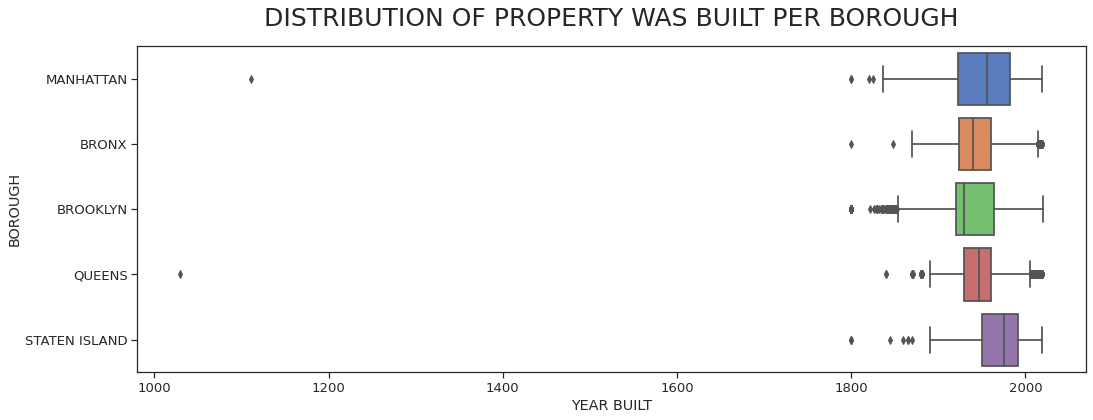

In [537]:
# Year built of properties sold across boroughs
plt.figure(figsize=(17,6))
sns.boxplot(x='YEAR BUILT', y='BOROUGH', data=nyc_property_sales)
plt.title('DISTRIBUTION OF PROPERTY WAS BUILT PER BOROUGH', fontsize=25, pad=20)
plt.show()

Most of the properties sold in our dataset were built between the years 1920 and 1990. 

## What affects Sale Price?

Does land square feet affect sale price?

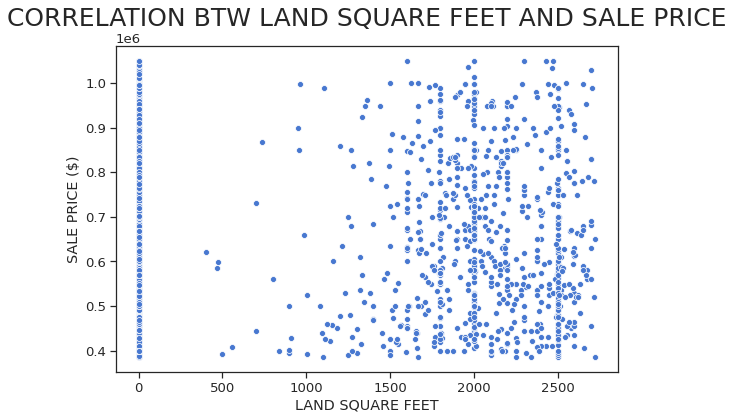

In [538]:
# Land square feet vs sale price
# For the plot, I excluded outliers (top and bottom 25%) and only graphed 20% of the population to it easier for the eyes.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['LAND SQUARE FEET'].between(nyc_property_sales['LAND SQUARE FEET'].quantile(.25), nyc_property_sales['LAND SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='LAND SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.title('CORRELATION BTW LAND SQUARE FEET AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [539]:
# correlation between sale price and land square feet
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['LAND SQUARE FEET'])

0.021909587780117704

There is almost no correlation (0.02 to be exact) between sale price and lands square feet.

So, what about gross square feet? Does that affect sale price?

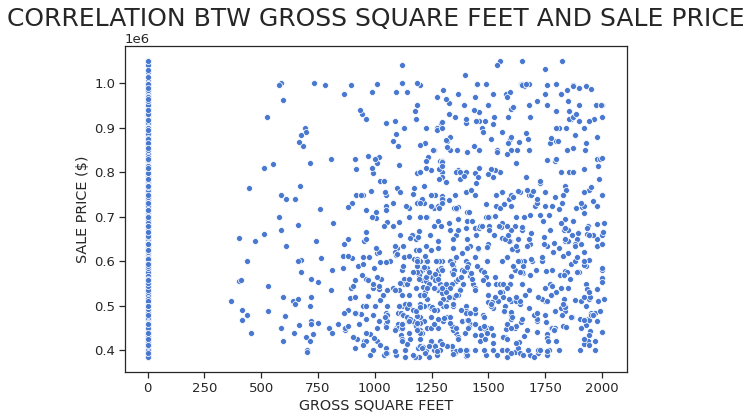

In [540]:
# Gross square feet vs sale price
# For the plot, I excluded outliers (top and bottom 25%) and only graphed 20% of the population to it easier for the eyes.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['GROSS SQUARE FEET'].between(nyc_property_sales['GROSS SQUARE FEET'].quantile(.25), nyc_property_sales['GROSS SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.title('CORRELATION BTW GROSS SQUARE FEET AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [541]:
# correlation of sale price and gross square feet
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['GROSS SQUARE FEET'])

0.4604122820011418

Although not visible in the graph, gross square feet has a slight correlation with sale price. The correlation between the two is 0.46. This correlation is higher than the one we found with land square feet which makes sense because gross square feet is usually greater than lands square feet and more floors and space means a higher price.

And what about the year in which the property was built? Does that affect sale price?

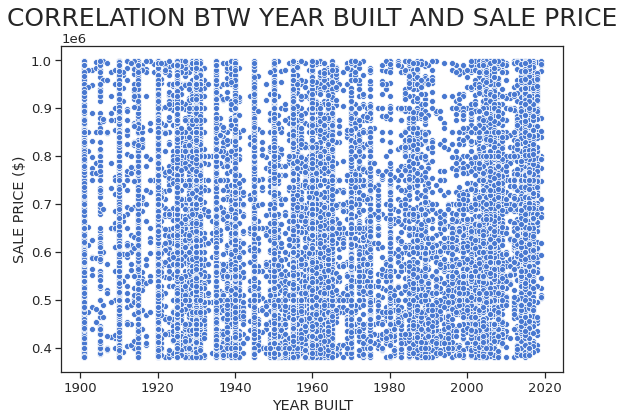

In [542]:
# Year built vs sale price
# For visual purposes, I excluded outliers (top and bottom 25%) and only graphed 20% of the population.
year_built_cleaned = nyc_property_sales[nyc_property_sales['YEAR BUILT']>1900]
x = year_built_cleaned[year_built_cleaned['SALE PRICE'].between(year_built_cleaned['SALE PRICE'].quantile(.25), year_built_cleaned['SALE PRICE'].quantile(.75))]
year_built_cleaned_sample = x.sample(frac=0.2)

sns.scatterplot(x='YEAR BUILT', y='SALE PRICE', data=year_built_cleaned_sample)
plt.title('CORRELATION BTW YEAR BUILT AND SALE PRICE', fontsize=25, pad=20)
plt.ylabel('SALE PRICE ($)')
plt.show()

In [544]:
# correlation of sale price and year built
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['YEAR BUILT'])

0.004102759021503976

There is no correlation between sale price and the year in which the property was built.

# Summary

Most of my time for this report was spent cleaning the data set. There were many null entries and false values that were dropped. With the data that was left, I found trends and that help me make the following insights:


*   NYC property price ranges greatly so there something for everyone's budget. 
*   Manhattan is not to the place to go to if you're looking for a more spacious property. 
*   Don't worry about the year the property was built affecting the price. Older and newers buildings can sell for similar prices.

